In [24]:
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

conv=nn.Conv1d(1, 1, 7, padding=3)

import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 64 #scale to 3,16 at least # dim must be divisible by 2
depth=4 #scale to 2, at least
hidden_dim=4 
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.01
cutoff=20.0
num_neighbors=8



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)[:10]
#print(all_paths)
split=0.75
t=int(len(all_paths) *.75) - 1

v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:t], all_paths[t:t+v-1]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis)
train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(1, 1).to(device)
pred_head2 = nn.Linear(1, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    #list(pred_head2.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 20 # or whatever you like
total_all    = "None"#count_params(torch.nn.ModuleList(
                    #[egnn_net, protein_egnn, pred_head, pred_head2,conv,rbf_layer,mha_layer]))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
#print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.permute(1,0,2))
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train()#pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval()#pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses:
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./test_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)


{'runid': '20250715_032808', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs/*.npz', 7), 'epochs': 20, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 'None'}
Epoch   0 | train L1 = 1.2874
              |  val L1 = 0.9153
Epoch   1 | train L1 = 1.2819
              |  val L1 = 0.9143
Epoch   2 | train L1 = 1.2783
              |  val L1 = 0.9106
Epoch   3 | train L1 = 1.2754
              |  val L1 = 0.9087
Epoch   4 | train L1 = 1.2733
              |  val L1 = 0.9077
Epoch   5 | train L1 = 1.2707
              |  val L1 = 0.9066
Epoch   6 | train L1 = 1.2674
              |  val L1 = 0.8957
Epoch   7 | train L1 = 1.2484
              |  val L1 = 0.8589
Epoch   8 | train L1 = 1.2215
              |  val L1 = 0.8290
Epoch   9 | train L1 = 1.2020
              |  val L1 = 0.7961
Epoch  10 | train L1 = 1.2053
              |  val L1 = 0.7715
Epoch  11 | train L1 = 1.1724
     

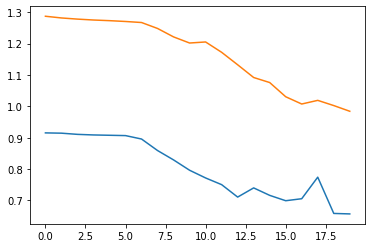

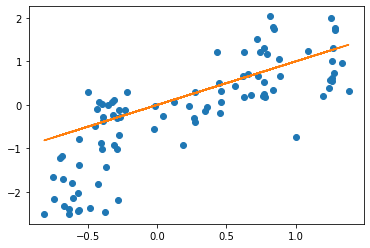

In [30]:

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
plt.show()
plt.plot(preds.flatten(),y_res.flatten(),"o")
plt.plot(preds.flatten(),preds.flatten())

Epoch   0 | train L1 = 0.9289
              |  val L1 = 0.6709
Epoch   1 | train L1 = 0.9253
              |  val L1 = 0.7401
Epoch   2 | train L1 = 0.9053
              |  val L1 = 0.6543
Epoch   3 | train L1 = 0.8761
              |  val L1 = 0.6591
Epoch   4 | train L1 = 0.8795
              |  val L1 = 0.7481
Epoch   5 | train L1 = 0.8447
              |  val L1 = 0.6581
Epoch   6 | train L1 = 0.8308
              |  val L1 = 0.6616
Epoch   7 | train L1 = 0.8199
              |  val L1 = 0.6668
Epoch   8 | train L1 = 0.7995
              |  val L1 = 0.6484
Epoch   9 | train L1 = 0.7842
              |  val L1 = 0.6141
Saved checkpoint_20250715_034717.pt (19.1 min) 19.1414461572965


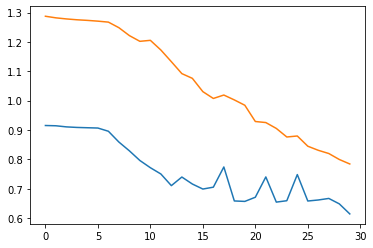

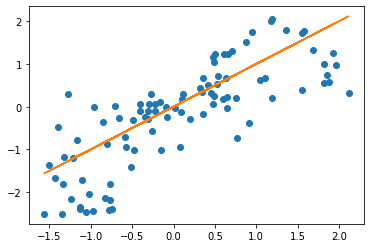

In [31]:
epochs=10
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train()#pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval()#pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses:
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./test_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
plt.show()
plt.plot(preds.flatten(),y_res.flatten(),"o")
plt.plot(preds.flatten(),preds.flatten())

Epoch   0 | train L1 = 0.7951
              |  val L1 = 0.6081
Epoch   1 | train L1 = 0.7978
              |  val L1 = 0.7218
Epoch   2 | train L1 = 0.7851
              |  val L1 = 0.6691
Epoch   3 | train L1 = 0.7798
              |  val L1 = 0.6877
Epoch   4 | train L1 = 0.7229
              |  val L1 = 0.7415
Epoch   5 | train L1 = 0.7230
              |  val L1 = 0.7720
Epoch   6 | train L1 = 0.7089
              |  val L1 = 0.7134
Epoch   7 | train L1 = 0.6732
              |  val L1 = 0.6567
Epoch   8 | train L1 = 0.7072
              |  val L1 = 0.6743
Epoch   9 | train L1 = 0.6437
              |  val L1 = 0.6986
Saved checkpoint_20250715_035410.pt (26.0 min) 26.027161800861357


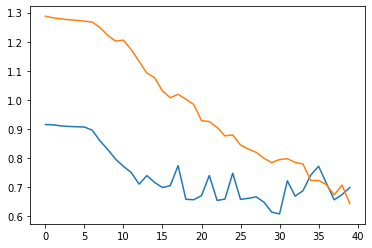

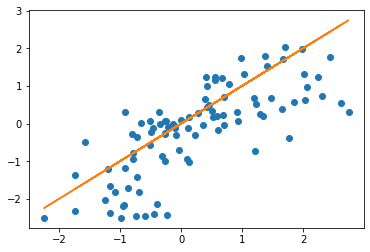

In [32]:
epochs=10
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train()#pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval()#pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses:
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./test_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
plt.show()
plt.plot(preds.flatten(),y_res.flatten(),"o")
plt.plot(preds.flatten(),preds.flatten())

Epoch   0 | train L1 = 0.6178
              |  val L1 = 0.6579
Epoch   1 | train L1 = 0.6467
              |  val L1 = 0.7816
Epoch   2 | train L1 = 0.6489
              |  val L1 = 0.6986
Epoch   3 | train L1 = 0.6311
              |  val L1 = 0.7629
Epoch   4 | train L1 = 0.6054
              |  val L1 = 0.6792
Epoch   5 | train L1 = 0.5995
              |  val L1 = 0.7248
Epoch   6 | train L1 = 0.5812
              |  val L1 = 0.7321
Epoch   7 | train L1 = 0.5725
              |  val L1 = 0.7291
Epoch   8 | train L1 = 0.5490
              |  val L1 = 0.7912
Epoch   9 | train L1 = 0.5896
              |  val L1 = 0.7309
Saved checkpoint_20250715_040056.pt (32.8 min) 32.78471255699794


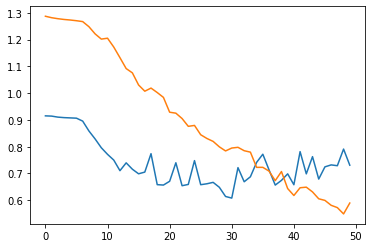

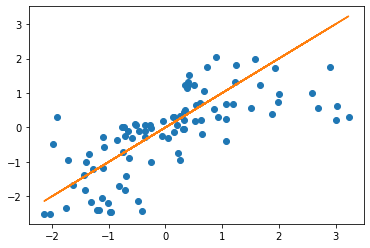

In [33]:
epochs=10
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train()#pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval()#pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses:
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./test_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
plt.show()
plt.plot(preds.flatten(),y_res.flatten(),"o")
plt.plot(y_res.flatten(),y_res.flatten())

Epoch   0 | train L1 = 0.5712
              |  val L1 = 0.6875
Epoch   1 | train L1 = 0.5876
              |  val L1 = 0.8711
Epoch   2 | train L1 = 0.5591
              |  val L1 = 0.7266
Epoch   3 | train L1 = 0.5207
              |  val L1 = 0.7885
Epoch   4 | train L1 = 0.5442
              |  val L1 = 0.7925
Saved checkpoint_20250715_040550.pt (37.7 min) 37.69776136477788


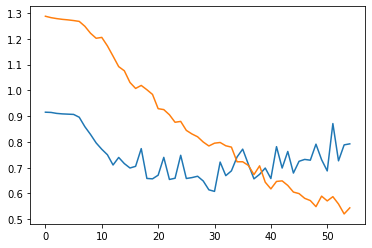

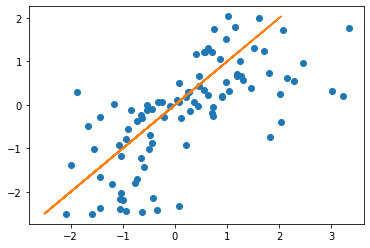

In [34]:
epochs=5
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train()#pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval()#pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses:
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./test_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
plt.show()
plt.plot(preds.flatten(),y_res.flatten(),"o")
plt.plot(y_res.flatten(),y_res.flatten())

In [22]:
#centroids.shape
t.shape

torch.Size([1, 138, 1])

In [15]:
#feats.shape
z_res.shape

torch.Size([138, 100])

In [ ]:
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+depth)
#tok=nconv(tok.permute(1,0,2))
nconv()



In [35]:
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

conv=nn.Conv1d(1, 1, 7, padding=3)

import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 64 #scale to 3,16 at least # dim must be divisible by 2
depth=4 #scale to 2, at least
hidden_dim=4 
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.01
cutoff=20.0
num_neighbors=8



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)[:20]
#print(all_paths)
split=0.75
t=int(len(all_paths) *.75) - 1

v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:t], all_paths[t:t+v-1]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis)
train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(1, 1).to(device)
pred_head2 = nn.Linear(1, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    #list(pred_head2.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 20 # or whatever you like
total_all    = "None"#count_params(torch.nn.ModuleList(
                    #[egnn_net, protein_egnn, pred_head, pred_head2,conv,rbf_layer,mha_layer]))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
#print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.permute(1,0,2))
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train()#pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval()#pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses:
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./test_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)


{'runid': '20250715_040735', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs/*.npz', 18), 'epochs': 20, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 'None'}
Epoch   0 | train L1 = 1.2613
              |  val L1 = 1.3681
Epoch   1 | train L1 = 1.2252
              |  val L1 = 1.3565
Epoch   2 | train L1 = 1.2208
              |  val L1 = 1.3503
Epoch   3 | train L1 = 1.2181
              |  val L1 = 1.3486
Epoch   4 | train L1 = 1.2198
              |  val L1 = 1.3493
Epoch   5 | train L1 = 1.2163
              |  val L1 = 1.3379
Epoch   6 | train L1 = 1.1945
              |  val L1 = 1.3043
Epoch   7 | train L1 = 1.1504
              |  val L1 = 1.2440
Epoch   8 | train L1 = 1.1282
              |  val L1 = 1.2232
Epoch   9 | train L1 = 1.1238
              |  val L1 = 1.2694
Epoch  10 | train L1 = 1.1183
              |  val L1 = 1.1907
Epoch  11 | train L1 = 1.0863
    

In [59]:
h_out, coords = egnn_net(z_res, x_res)          # h_out is [tensor] or tensor
h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

# ---------- RBF on *input* coords (already (R,N,3)) ----------
#d   = torch.cdist(x_r, x_r)            # (R, N, N)
rbf = rbf_layer(coords)                     # (R, N, N, basis)


# ---------- concat & attention ----------
h0  = h.transpose(1, 2)                # (R, dim,   N)
r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
tok2=nconv(tok.permute(1,0,2))
#tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
#return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                        # (R, dim+basis)


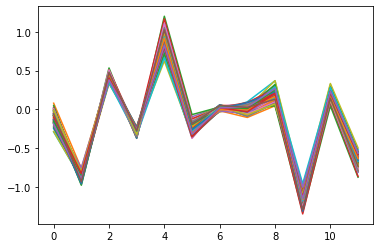

In [57]:
for hi in h:
    plt.plot(torch.mean(hi,dim=0).detach().numpy())

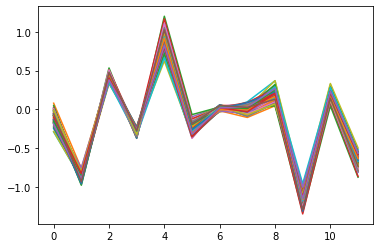

In [68]:
for hi in h:
    plt.plot(torch.mean(hi,dim=0).detach().numpy())

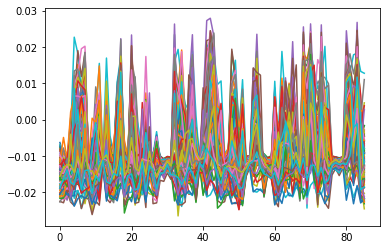

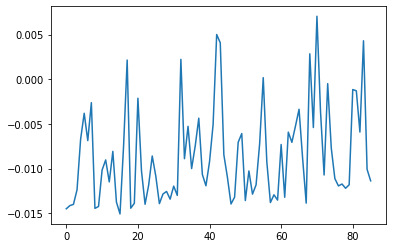

In [81]:
for hi in tok:
    plt.plot(torch.mean(hi,dim=-1).detach().numpy())
plt.show()
plt.plot(torch.mean(torch.mean(tok,dim=-1),dim=0).flatten().detach().numpy())

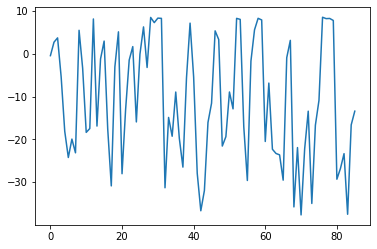

In [78]:
plt.plot(tok2.flatten().detach().numpy())

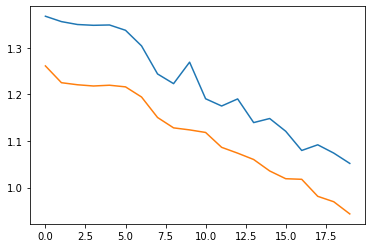

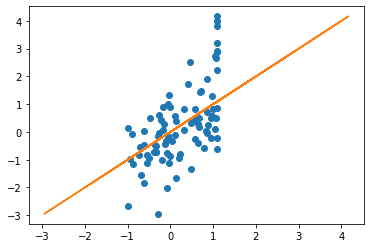

In [36]:
from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
plt.show()
plt.plot(preds.flatten(),y_res.flatten(),"o")
plt.plot(y_res.flatten(),y_res.flatten())